# SWG + Diffusion Models with Transformer (DiT)

# 1. Setup


In [1]:
import torch
import os
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL

from diffusion.models import find_model
from diffusion.models import DiT_XL_2
from PIL import Image
import PIL.Image
from IPython.display import display

torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

os.makedirs("samples", exist_ok=True)

image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8

model = DiT_XL_2(input_size=latent_size,strict_img_size=False).to(device)
state_dict = find_model(f"./pretrained_models/DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
g_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
samples_per_row = 5 #@param {type:"number"}

def get_latents(seed = 0):
    torch.manual_seed(seed)
    class_labels = (207, 360, 387, 417, 88, 979, 279) #,  #@param {type:"raw"}

    # Create diffusion object:
    diffusion = create_diffusion(str(num_sampling_steps))
    # Create sampling noise:
    n = len(class_labels)
    z = torch.randn(n, 4, latent_size, latent_size, device=device)
    y = torch.tensor(class_labels, device=device)
    return diffusion, z, y

/home/adaloglo/swg_bmvc2025_official/edm2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/adaloglo/swg_bmvc2025_official/edm2/.venv/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/adaloglo/swg_bmvc2025_official/edm2/.venv/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/adaloglo/swg_bmvc2025_official/edm2/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume

# 2. SWG guidance

In [2]:
import PIL.Image

def saves_images_custom(samples, folder):
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)
    
    images_np = (samples * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()    
    for i, img in enumerate(images_np):
        PIL.Image.fromarray(img, 'RGB').save(os.path.join(folder, f'img_{str(i).zfill(3)}.png'))
        
for g_scale in [0.2, 0.5 ,1 ,2]:
    diffusion , z, y = get_latents(seed = 0)
    model_kwargs = dict(y=y, g_scale=g_scale)

    samples = diffusion.p_sample_loop(
        model.forward_with_crop, z.shape, z, clip_denoised=False, 
        model_kwargs=model_kwargs, progress=True, device=device)
    samples = vae.decode(samples / 0.18215).sample

    # Save and display images:
    folder = f"samples/visuals/SWG/w_{g_scale}"
    saves_images_custom(samples, folder)

100%|██████████| 250/250 [01:17<00:00,  3.24it/s]


# Base (no guidance)

In [3]:
diffusion , z, y = get_latents(seed = 0)
model_kwargs = dict(y=y)

# Sample images:
samples = diffusion.p_sample_loop(
    model.forward, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device)

samples = vae.decode(samples / 0.18215).sample

# Save and display images:
folder = f"samples/visuals/no_guidance/"
saves_images_custom(samples, folder)

100%|██████████| 250/250 [00:27<00:00,  9.03it/s]


# 3. Vanilla CFG

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [4]:
# Setup classifier-free guidance:
for g_scale in [1, 1.5, 2, 2.5]: 
    diffusion, z, y = get_latents(seed = 0)

    z_cfg = torch.cat([z, z], 0)
    y_null = torch.tensor([1000] * len(y), device=device)
    y_cfg = torch.cat([y, y_null], 0)
    model_kwargs = dict(y=y_cfg, g_scale=g_scale)

    # Sample images:
    samples = diffusion.p_sample_loop(
        model.forward_with_cfg, z_cfg.shape, z_cfg, clip_denoised=False, 
        model_kwargs=model_kwargs, progress=True, device=device
    )

    samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
    samples = vae.decode(samples / 0.18215).sample

    # Save and display images:
    folder = f"samples/visuals/CFG/w_{g_scale-1}"
    saves_images_custom(samples, folder)

100%|██████████| 250/250 [00:52<00:00,  4.80it/s]


# 4. Combine SWG with CFG

In [5]:
# Setup classifier-free guidance:
for g_scale in [0.4, 0.8, 1]:
    for crop_scale in [0.2, 0.5, 1]:
        diffusion, z, y = get_latents(seed = 0)
        z_cfg = torch.cat([z, z], 0)
        y_null = torch.tensor([1000] * len(y), device=device)
        y_cfg = torch.cat([y, y_null], 0)
        model_kwargs = dict(y=y_cfg, g_scale=g_scale,crop_scale=crop_scale)

        # Sample images:
        samples = diffusion.p_sample_loop(
            model.forward_with_cfg_crop, z_cfg.shape, z_cfg, clip_denoised=False, 
            model_kwargs=model_kwargs, progress=True, device=device
        )
        samples_chunked, _ = samples.chunk(2, dim=0)  # Remove null class samples
        samples_final = vae.decode(samples_chunked / 0.18215).sample

        # Save and display images:
        folder = f"samples/visuals/CFG_SWG/w_{g_scale}_{crop_scale}"
        saves_images_custom(samples_final, folder)

100%|██████████| 250/250 [01:41<00:00,  2.46it/s]


Methods found: ['CFG', 'CFG_SWG', 'SWG']


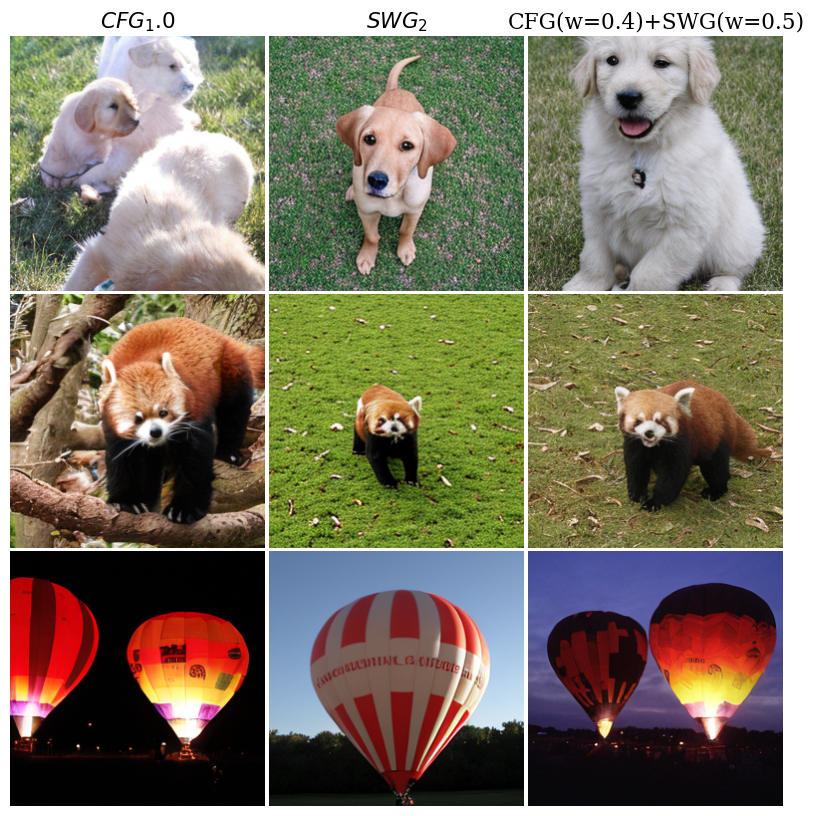

In [6]:
import glob
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
fontsize = 13
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams["mathtext.cal"] = 'cursive'
plt.rcParams.update({'font.size': fontsize})

# Use relative path for portability
path = './samples/visuals/*/*/img*.png'
files = sorted(glob.glob(path))
methods = list(set([Path(x).parts[-3] for x in files]))
print('Methods found:', methods)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
plt.subplots_adjust(wspace=0.01, hspace=0.01)
img_ids = ['000', '002', '003']
# Clear axes in case of missing images
for ax_row in axes:
    for ax in ax_row:
        ax.axis('off')

for f in files:
    try:
        if Path(f).parts[-3] == 'CFG':
            img = Image.open(f)
            sample_id = Path(f).parts[-1].split('_')[-1].split('.')[0]
            w = float(Path(f).parts[-2].split('_')[-1]) # guidance scale
            if w == 1 and sample_id in img_ids:
                index_img_id = img_ids.index(sample_id)
                axes[index_img_id, 0].imshow(img)
                axes[index_img_id, 0].axis('off')
                if index_img_id == 0:
                    axes[index_img_id, 0].set_title(f'$CFG_{w}$')
        elif Path(f).parts[-3] == 'SWG':
            w_desired = 2
            img = Image.open(f)
            sample_id = Path(f).parts[-1].split('_')[-1].split('.')[0]
            w = float(Path(f).parts[-2].split('_')[-1])
            if w == w_desired and sample_id in img_ids:
                index_img_id = img_ids.index(sample_id)
                axes[index_img_id, 1].imshow(img)
                axes[index_img_id, 1].axis('off')
                if index_img_id == 0:
                    axes[index_img_id, 1].set_title(f'$SWG_{w_desired}$')
        elif 'CFG_SWG' in Path(f).parts[-3]:
            img = Image.open(f)
            sample_id = Path(f).parts[-1].split('_')[-1].split('.')[0]
            w_cfg = float(Path(f).parts[-2].split('_')[-2])
            w_swg = float(Path(f).parts[-2].split('_')[-1])
            if w_swg == 0.5 and w_cfg == 0.4 and sample_id in img_ids:
                index_img_id = img_ids.index(sample_id)
                axes[index_img_id, 2].imshow(img)
                axes[index_img_id, 2].axis('off')
                if index_img_id == 0:
                    axes[index_img_id, 2].set_title(f'CFG(w={w_cfg})+SWG(w={w_swg})')
    except Exception as e:
        print(f'Error processing {f}: {e}')

plt.savefig('samples/teaser_CFG_SWG1.pdf', bbox_inches='tight', dpi=200)
plt.show()

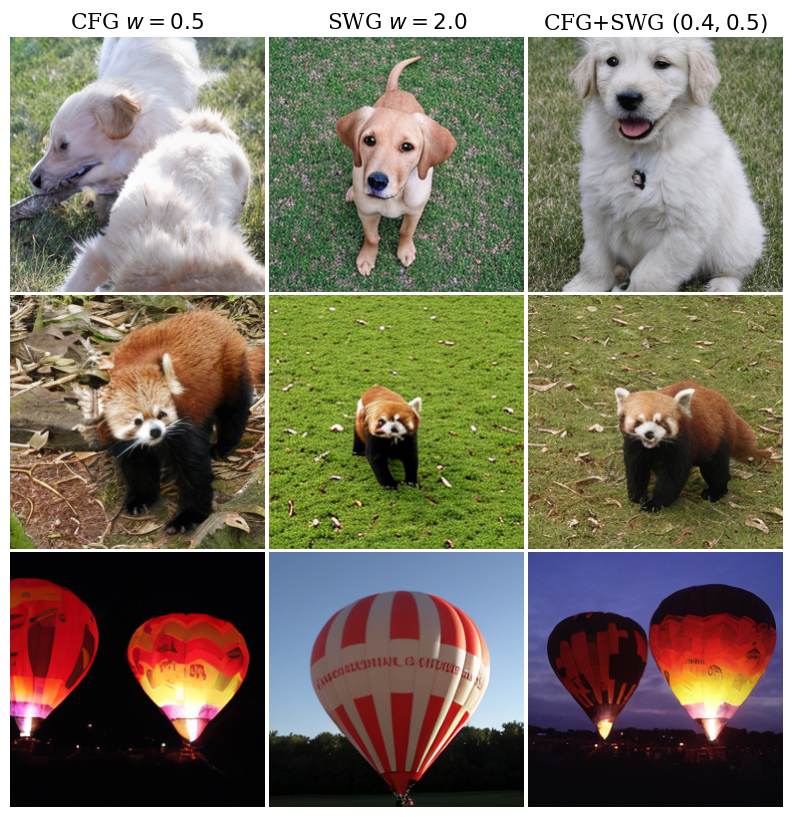

In [7]:
import glob
import os 
from pathlib import Path
import matplotlib.pyplot as plt
fontsize= 13
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams["mathtext.cal"] = 'cursive'
plt.rcParams.update({'font.size': fontsize})

path = './samples/visuals/*/*/img*.png'
files = sorted(glob.glob(path))
methods = list(set([Path(x).parts[-3] for x in files]))
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
plt.subplots_adjust(wspace=0.01, hspace=0.01)
img_ids = ['000', '002' , '003']
for f in files:
    if Path(f).parts[-3] =='CFG':
        img = Image.open(f)
        sample_id = Path(f).parts[-1].split('_')[-1].split('.')[0]
        w = float(Path(f).parts[-2].split('_')[-1]) # guidance scale
        if w==0.5 and sample_id in img_ids:
            index_img_id = img_ids.index(sample_id)
            axes[index_img_id, 0].imshow(img)
            axes[index_img_id, 0].axis('off')
            if index_img_id == 0:
                axes[index_img_id, 0].set_title(f'CFG $w={w}$')
    if Path(f).parts[-3] =='SWG':
        img = Image.open(f)
        sample_id = Path(f).parts[-1].split('_')[-1].split('.')[0]
        w = float(Path(f).parts[-2].split('_')[-1])
        if w==2 and sample_id in img_ids: 
            index_img_id = img_ids.index(sample_id)
            axes[index_img_id, 1].imshow(img)
            axes[index_img_id, 1].axis('off')
            if index_img_id == 0:
                axes[index_img_id, 1].set_title(f'SWG $w={w}$')
    
    if '_SWG' in f:
        # Combined CFG + SWG
        g_swg, g_cfg = 0.5, 0.4 # Desired weights
        img = Image.open(f)
        sample_id = Path(f).parts[-1].split('_')[-1].split('.')[0]
        
        w_cfg = float(Path(f).parts[-2].split('_')[-2])
        w_swg = float(Path(f).parts[-2].split('_')[-1])
        if w_swg == g_swg and w_cfg==g_cfg and sample_id in img_ids:
            index_img_id = img_ids.index(sample_id)
            axes[index_img_id, 2].imshow(img)
            axes[index_img_id, 2].axis('off')
            if index_img_id == 0:
                axes[index_img_id, 2].set_title(f'CFG+SWG (${w_cfg},{w_swg})$')

plt.savefig('samples/teaser_CFG_SWG.png', bbox_inches='tight', dpi=200)
plt.show()
    